In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle

sns.set_theme(style="white", palette=None)
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])

In [3]:
import sys
sys.path.append('../src')
from data.audio_dataset import AudioSpectrogramDataset
from models.PGAN_model.PGAN import PGAN

import torch
import pytorch_lightning as pl
import librosa
import soundfile as sf
from torch.utils.data import DataLoader

C:\Users\micha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
# # hyperparameters
# z_dim = 100
latent_dim = 100
output_dim = 1
negative_slope = 0.2
init_resolution_size=(8,5)
batch_size = 32
depths = [256, 256, 128, 64, 32, 16]
num_epochs = 6
num_epochs_per_resolution = int(num_epochs / len(depths))
learning_rate = 0.001
# beta1 = 0.5

normalization = True
mini_batch_normalization = False

# base_directory = "../data/raw/nsynth-train/audio"
base_directory = "../data/raw/Bass"

dataset = AudioSpectrogramDataset(base_directory=base_directory, spectro_type='mel')
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [12]:
dataiter = iter(dataloader)
spectrograms = next(dataiter)
spectrograms.shape

torch.Size([32, 1, 256, 160])

In [14]:
Music_PGAN = PGAN(
    latent_dim=latent_dim,
    output_dim=output_dim,
    lr=learning_rate,
    depths=depths, 
    negative_slope=negative_slope,
    normalization=normalization,
    mini_batch_normalization=mini_batch_normalization,
    init_resolution_size=init_resolution_size,
    num_epochs_per_resolution=num_epochs_per_resolution,
)

In [15]:
Music_PGAN.train(dataloader=dataloader, fade_in_percentage=0.5)

Resolution 0 - Epoch 1/1 - D Loss: 0.45485758781433105 - G Loss: 0.24823535978794098
Resolution 1 - Epoch 1/1 - D Loss: 0.4113001227378845 - G Loss: 0.731676459312439
Resolution 2 - Epoch 1/1 - D Loss: 0.35679686069488525 - G Loss: 0.6919211745262146
Resolution 3 - Epoch 1/1 - D Loss: 0.43321728706359863 - G Loss: 0.48646730184555054
Resolution 4 - Epoch 1/1 - D Loss: 0.4939552843570709 - G Loss: 0.26720309257507324
Resolution 5 - Epoch 1/1 - D Loss: 0.4992920756340027 - G Loss: 0.2512351870536804


In [16]:
Music_PGAN.writer.close()

In [17]:
Music_PGAN.generator.eval()

PGenerator(
  (blocks): ModuleList(
    (0): ModuleList(
      (0): Sequential(
        (0): Upsample(scale_factor=2.0, mode=nearest)
        (1): ConvTranspose2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (2): LeakyReLU(negative_slope=0.2)
        (3): ConvTranspose2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): LeakyReLU(negative_slope=0.2)
      )
      (1): Sequential(
        (0): Conv2d(256, 1, kernel_size=(1, 1), stride=(1, 1))
      )
    )
    (1): ModuleList(
      (0): Sequential(
        (0): Upsample(scale_factor=2.0, mode=nearest)
        (1): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (2): LeakyReLU(negative_slope=0.2)
        (3): ConvTranspose2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): LeakyReLU(negative_slope=0.2)
      )
      (1): Sequential(
        (0): Conv2d(128, 1, kernel_size=(1, 1), stride=(1, 1))
      )
    )
    (2): ModuleList(

In [18]:
z = torch.randn(1, Music_PGAN.latent_dim).to(Music_PGAN.device)
generated_spectrogram = Music_PGAN.generator(z)

In [19]:
spectrogram = generated_spectrogram.cpu().detach().numpy()
print(spectrogram.shape)
spectrogram = spectrogram.squeeze()
print(spectrogram.shape)

(1, 1, 256, 160)
(256, 160)


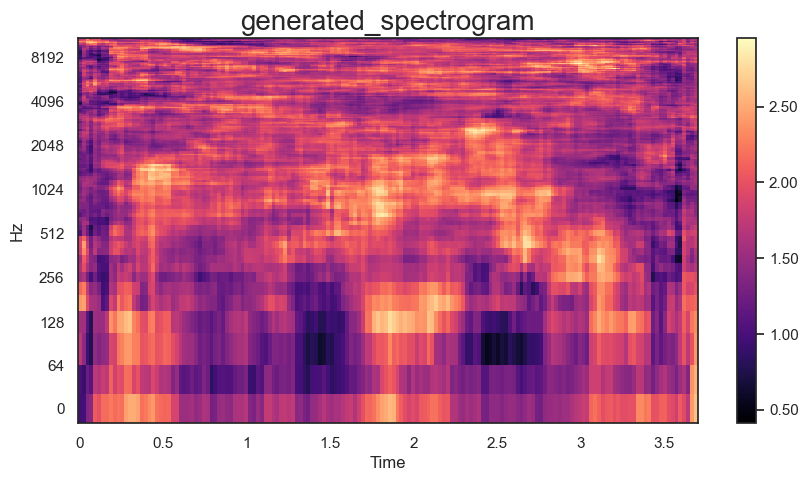

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

img = librosa.display.specshow(spectrogram, x_axis='time', y_axis='log')
plt.title('generated_spectrogram', fontsize=20)
plt.colorbar(img, format='%0.2f')

plt.show()

In [62]:
audio = librosa.feature.inverse.mel_to_audio(spectrogram)

path = '../models/generated_samples/'
file_name = 'PGAN_generated_audio.wav'

sf.write(path + file_name, audio, 22050)